In [ ]:
%pip install kagglehub
%pip install mlflow

!git clone https://github.com/ultralytics/yolov5 
!pip install -U pycocotools
!pip install -qr yolov5/requirements.txt 
!cp yolov5/requirements.txt ./
%pip install yt-dlp


In [2]:
import kagglehub

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import zipfile
import os
import urllib.request
from tqdm import tqdm
from tqdm import notebook 
import time
import random
import shutil as sh

import cv2
from yolov5 import detect
import torch

from IPython.display import Image, clear_output, display, Video


### Подготовка данных

In [3]:
path = kagglehub.dataset_download("sshikamaru/car-object-detection")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\vanya\.cache\kagglehub\datasets\sshikamaru\car-object-detection\versions\2


In [4]:
train_solutions = pd.read_csv(path + '/data/train_solution_bounding_boxes (1).csv')
train_solutions.head()

image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422

In [5]:
sample_submissions = pd.read_csv(path + '/data/sample_submission.csv')
sample_submissions.head()

image                           bounds
0  vid_5_26560.jpg  0.0 0.0 1.0 1.0 0.0 0.0 1.0 1.0
1  vid_5_26580.jpg  0.0 0.0 1.0 1.0 0.0 0.0 1.0 1.0
2  vid_5_26600.jpg                  0.0 0.0 1.0 1.0
3  vid_5_26620.jpg                  0.0 0.0 1.0 1.0
4  vid_5_26640.jpg                  0.0 0.0 1.0 1.0

In [6]:
img_h, img_w, num_channels = (380, 676, 3) 

train_solutions.rename(columns={'image':'image_id'}, inplace=True) 
train_solutions['image_id'] = train_solutions['image_id'].apply(lambda x: x.split('.')[0])

train_solutions['x_center'] = (train_solutions['xmin'] + train_solutions['xmax'])/2 
train_solutions['y_center'] = (train_solutions['ymin'] + train_solutions['ymax'])/2

train_solutions['w'] = train_solutions['xmax'] - train_solutions['xmin'] 
train_solutions['h'] = train_solutions['ymax'] - train_solutions['ymin']

train_solutions['classes'] = 0
train_solutions['x_center'] = train_solutions['x_center']/img_w
train_solutions['w'] = train_solutions['w']/img_w
train_solutions['y_center'] = train_solutions['y_center']/img_h
train_solutions['h'] = train_solutions['h']/img_h
train_solutions.head()

image_id        xmin        ymin        xmax        ymax  x_center  \
0   vid_4_1000  281.259045  187.035071  327.727931  223.225547  0.450434   
1  vid_4_10000   15.163531  187.035071  120.329957  236.430180  0.100217   
2  vid_4_10040  239.192475  176.764801  361.968162  236.430180  0.444645   
3  vid_4_10020  496.483358  172.363256  630.020260  231.539575  0.833213   
4  vid_4_10060   16.630970  186.546010  132.558611  238.386422  0.110347   

   y_center         w         h  classes  
0  0.539817  0.068741  0.095238        0  
1  0.557191  0.155572  0.129987        0  
2  0.543678  0.181621  0.157014        0  
3  0.531451  0.197540  0.155727        0  
4  0.559122  0.171491  0.136422        0

In [7]:
index = list(set(train_solutions.image_id))
image = random.choice(index)
print("Image ID: %s"%(image))
img = cv2.imread(f'{path}/data/training_images/{image}.jpg')
img.shape

Image ID: vid_4_12100


(380, 676, 3)

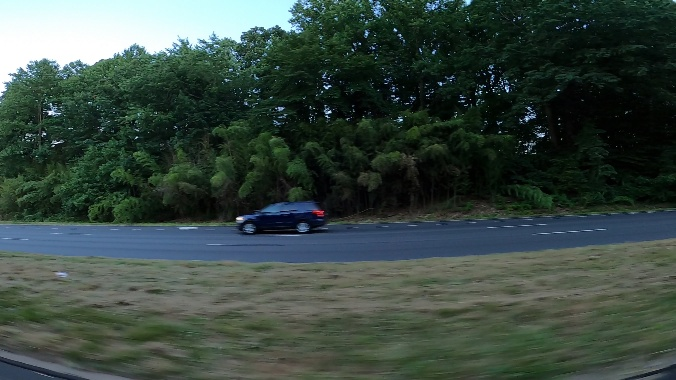

In [8]:
image = random.choice(index)
Image(filename=f'{path}/data/training_images/{image}.jpg',width=600)

In [9]:
source = 'training_images'

for fold in [0]:
    val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
    for name, mini in tqdm(train_solutions.groupby('image_id')):
        if name in val_index:
            path2save = 'val2017/'
        else:
            path2save = 'train2017/'

        label_path = f'/tmp/convertor/fold{fold}/labels/{path2save}'
        if not os.path.exists(label_path):
            os.makedirs(label_path)

        with open(f'{label_path}{name}.txt', 'w+') as f:
            row = mini[['classes', 'x_center', 'y_center', 'w', 'h']].astype(float).values
            row = row.astype(str)
            for j in range(len(row)):
                text = ' '.join(row[j])
                f.write(text + "\n")

        image_path = f'/tmp/convertor/fold{fold}/images/{path2save}'
        if not os.path.exists(image_path):
            os.makedirs(image_path)


        image_file_path = f"{path}/data/training_images/{name}.jpg"  
        if os.path.exists(image_file_path):
            sh.copy(image_file_path, f'{image_path}/{name}.jpg')
        else:
            print(f"Image {name}.jpg not found.")

100%|██████████| 355/355 [00:00<00:00, 798.07it/s]


### Обучение и тестирование

In [10]:
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source {path}/data/testing_images --project ./output_detection
# this part of the code determines the directories for the yolofile the weights to be loaded,
# setting the input imgae sizes, and confidence score setup

detect: weights=['yolov5/yolov5s.pt'], source=C:\Users\vanya\.cache\kagglehub\datasets\sshikamaru\car-object-detection\versions\2/data/testing_images, data=yolov5\data\coco128.yaml, imgsz=[676, 676], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=./output_detection, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-378-g2f74455a Python-3.9.19 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1060 3GB, 3072MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
WARNING  --img-size [676, 676] must be multiple of max stride 32, updating to [704, 704]
image 1/175 C:\Users\vanya\.cache\kagglehub\datasets\sshikamaru\car-object-detection\versions\2\data\testing_images\vid_5_2

In [11]:
predicted_files = []
for (dirpath, dirnames, filenames) in os.walk("./yolov5/runs/detect/exp"):
    predicted_files.extend(filenames)

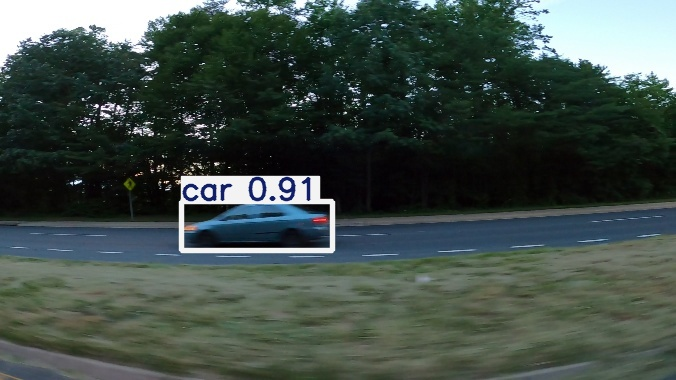

In [12]:
Image(filename='./output_detection/exp/vid_5_26580.jpg')

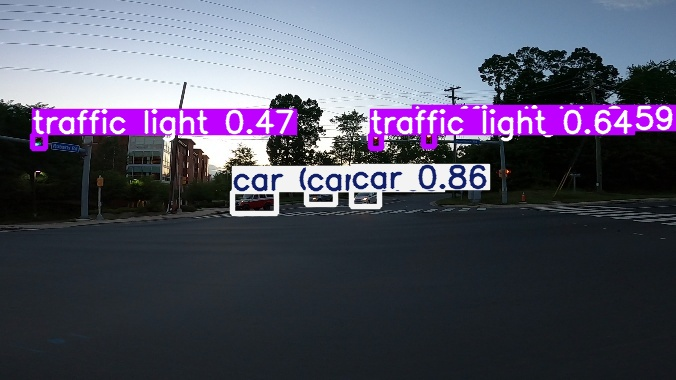

In [13]:
Image(filename='./output_detection/exp/vid_5_27420.jpg')

### Загрузка видео

In [14]:
!yt-dlp -f best "https://www.youtube.com/watch?v=wqctLW0Hb_0" -o "video.mp4"


[youtube] Extracting URL: https://www.youtube.com/watch?v=wqctLW0Hb_0
[youtube] wqctLW0Hb_0: Downloading webpage
[youtube] wqctLW0Hb_0: Downloading ios player API JSON
[youtube] wqctLW0Hb_0: Downloading mweb player API JSON
[youtube] wqctLW0Hb_0: Downloading m3u8 information
[info] wqctLW0Hb_0: Downloading 1 format(s): 18
[download] video.mp4 has already been downloaded

[download] 100% of   84.00MiB


         To let yt-dlp download and merge the best available formats, simply do not pass any format selection.
         If you know what you are doing and want only the best pre-merged format, use "-f b" instead to suppress this warning


In [15]:
def detect_objects_on_video(video_path):

    if not os.path.exists(video_path):
        print(f"Video file not found: {video_path}")
        return

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return

    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))

    results = detect.run(weights="yolov5/yolov5s.pt",
                    source=video_path,
                    conf_thres=0.4,
                    imgsz=(frame_width, frame_height), 
                    project="./", 
                    name="output_video",  
                    exist_ok=True 
                    )

detect_objects_on_video("./video.mp4")

YOLOv5  v7.0-378-g2f74455a Python-3.9.19 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1060 3GB, 3072MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
WARNING  --img-size [640, 360] must be multiple of max stride 32, updating to [640, 384]
video 1/1 (1/51201) D:\_python\projects\project_cv\car_detection\video.mp4: 224x384 8 cars, 1 truck, 26.1ms
video 1/1 (2/51201) D:\_python\projects\project_cv\car_detection\video.mp4: 224x384 8 cars, 1 truck, 6.1ms
video 1/1 (3/51201) D:\_python\projects\project_cv\car_detection\video.mp4: 224x384 8 cars, 1 truck, 5.0ms
video 1/1 (4/51201) D:\_python\projects\project_cv\car_detection\video.mp4: 224x384 8 cars, 1 truck, 6.1ms
video 1/1 (5/51201) D:\_python\projects\project_cv\car_detection\video.mp4: 224x384 8 cars, 1 truck, 6.0ms
video 1/1 (6/51201) D:\_python\projects\project_cv\car_detection\video.mp4: 224x384 8 cars, 1 truck, 6.1ms
video 1/1 (7/51201) D:\_python\projects\project_cv\car_detection\video

In [16]:
display(Video("./output_video/output_video.mp4", embed=True))